[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/stan/jet/notebooks/Normal_Crossing_SGLD_trajectory_notebook.ipynb)

# Normal Crossing SGLD trajectory notebook

This notebook uses SGLD to sample from the posterior around a point, for a polynomial model characterized by $y_{pred} = w_1^a * w_2^b * x$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned and $x$ is our (1-dimensional) input.

Both the input $x$ and target data $y$ are generated using (independent) gaussian noise, and the loss is Mean Squared Error from $y$ to $y_{pred}$, so the model achieves its lowest loss when $w_1=0$ or $w_2=0$.


#Setup (skippable)

In [1]:
!pip uninstall devinterp -y
%cd ..
!pip install -e .
# !pip install git+https://github.com/timaeus-research/devinterp.git@stan/jet

Found existing installation: devinterp 1.2.0
Uninstalling devinterp-1.2.0:
  Successfully uninstalled devinterp-1.2.0
/home/svwin/devinterp
Obtaining file:///home/svwin/devinterp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for devinterp (pyproject.toml) ... done
  Created wheel for devinterp: filename=devinterp-1.2.0-0.editable-py3-none-any.whl size=3324 sha256=3b714dc896fd3b5a2671e206453988a8798e9ae9f59307091603ff7d1d6c6ffe
  Stored in directory: /tmp/pip-ephem-wheel-cache-bfeatabf/wheels/bb/ea/fd/e16671b75d7d6a99197aa21701965c24d5fcd966f892e29ec1
Successfully built devinterp


In [2]:
# @title
import os
import locale


def getpreferredencoding(do_setlocale=True):
    return "UTF-8"


locale.getpreferredencoding = getpreferredencoding

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.llc import OnlineLLCEstimator
from devinterp.slt.sampler import sample
from devinterp.utils import default_nbeta, evaluate
from functools import partial

from devinterp.jet_tools.plot import *
from devinterp.jet_tools.models import *
from devinterp.jet_tools.diffs import *
from devinterp.jet_tools.utils import *

evaluate_mae = partial(evaluate, F.l1_loss)

# **Auxiliary functions**

In [3]:
# plotting
sns.set_style("whitegrid")

# plotting
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]


def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i : i + 2], 16) / 255.0 for i in (0, 2, 4))


lighter_factor = 0.9  # Between 0 and 1, higher values make it closer to white
lighter_SECONDARY = tuple(
    [x + (1 - x) * lighter_factor for x in hex_to_rgb(SECONDARY)[:3]] + [1.0]
)

colors = [SECONDARY, lighter_SECONDARY]
n_bins = 20  # Number of bins
contour_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
SEED = 0
SIGMA = 1
NUM_TRAIN_SAMPLES = 1000
BATCH_SIZE = NUM_TRAIN_SAMPLES
EVALUATE = evaluate_mae

train_loader, train_data, x, y = generate_dataset_for_seed(
    seed=SEED, sigma=SIGMA, batch_size=BATCH_SIZE, num_samples=NUM_TRAIN_SAMPLES
)

# **Model definition**

In [6]:
INITIAL_PARAMETERS = [0.0, 0.0]
A_B = [
    6,
    6,
]  # MSE loss function and zero-mean gaussian, so this is effectively w_1**2 * w_2**4 as loss, NB

nbeta = default_nbeta(len(train_data))  # = n/log(n)
model = SumModel(torch.tensor(A_B).to(DEVICE), DEVICE).to(
    DEVICE
)  # lol idk which one it should be
model.weights = nn.Parameter(
    torch.tensor(INITIAL_PARAMETERS, dtype=torch.float32, requires_grad=True).to(DEVICE)
)

# **SGLD trajectories sampling**


In [7]:
sampling_method = SGLD
# Number and length of chains
num_chains_sgld = 1
num_draws_sgld = 20_00

# SGLD parameters
epsilon_sgld = 0.005

In [8]:
torch.manual_seed(SEED)
np.random.seed(SEED)
weights = WeightCallback(
    num_chains=num_chains_sgld, num_draws=num_draws_sgld, model=model
)

online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgld,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)

trace_sgld = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(lr=epsilon_sgld, nbeta=nbeta, bounding_box_size=3.0),
    sampling_method=sampling_method,
    num_chains=num_chains_sgld,  # independent sampling runs
    num_draws=num_draws_sgld,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, weights],
    seed=SEED,
)

/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:225: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:264: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:291: UserWarning: You are using seeded runs, for full reproducibility check https://pytorch.org/docs/stable/notes/randomness.html
  warnings.warn(
Chain 0: 100%|██████████| 2000/2000 [00:18<00:00, 109.16it/s]
/home/svwin/devinterp/src/devinterp/slt/llc.py:149: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  s

In [9]:
wt_sgld = np.array(weights.get_results()["ws/trace"])

# numpy running mean of llc_chain (does not work yet with multiple chains)
llc_chain = online_llc_estimator.get_results()["llc/trace"]
# llc_chain = np.cumsum(llc_chain) / np.arange(1, len(llc_chain[0]) + 1)
print(np.nonzero(np.isnan(wt_sgld)))
print(epsilon_sgld * num_draws_sgld)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
10.0


# **SGLD plots**

## **Plotting SGLD trajectories and jet coordinates**

(2000, 1, 2)


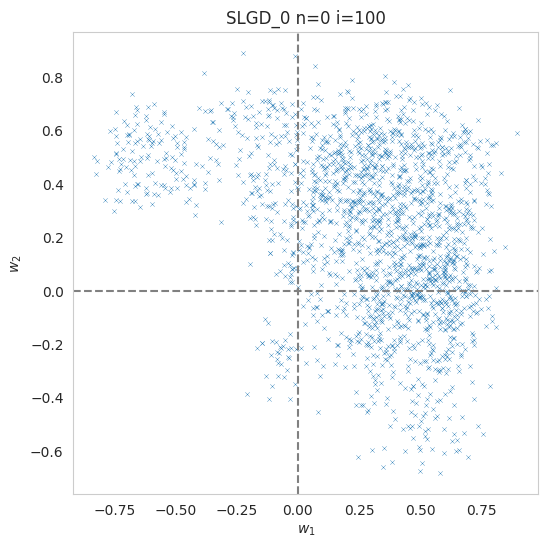

(2000, 1, 2)


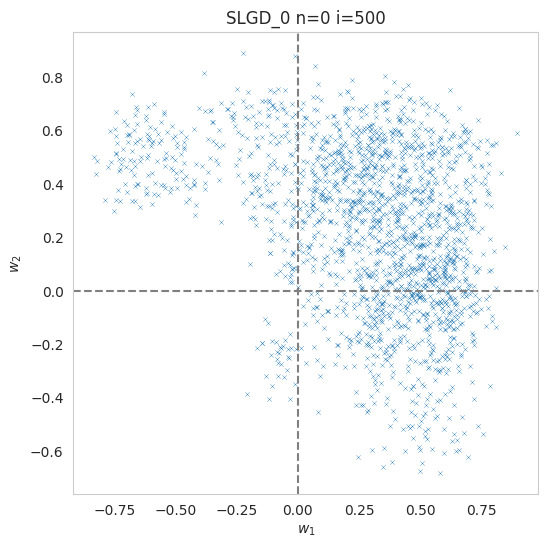

(1900, 1, 2)


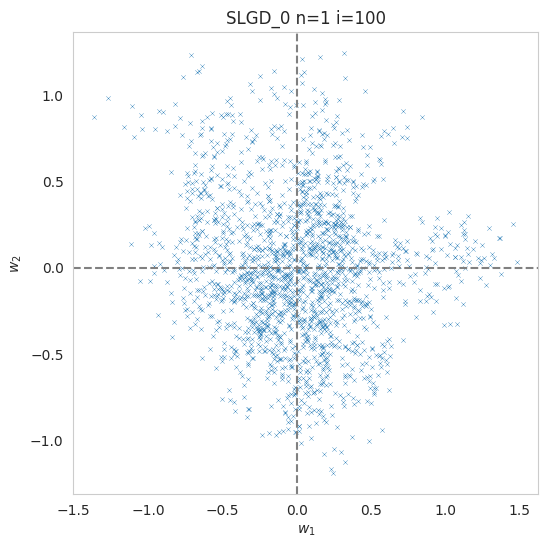

(1500, 1, 2)


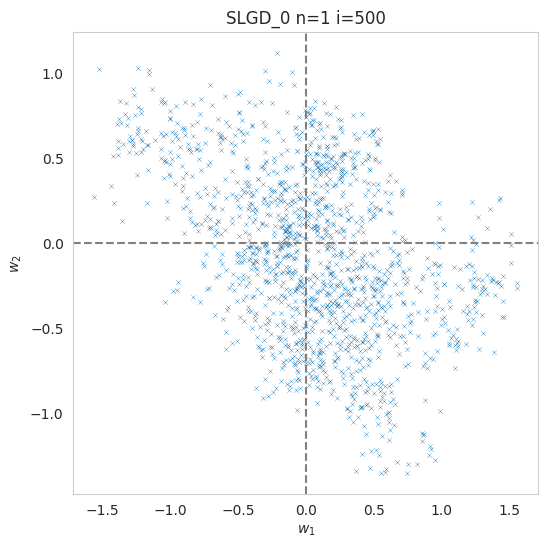

(1800, 1, 2)


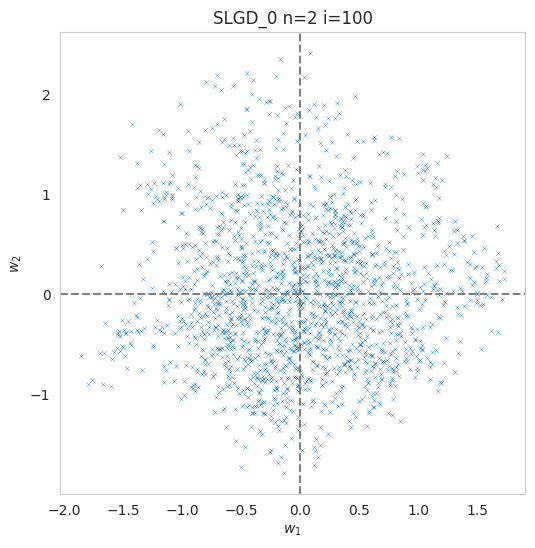

(1000, 1, 2)


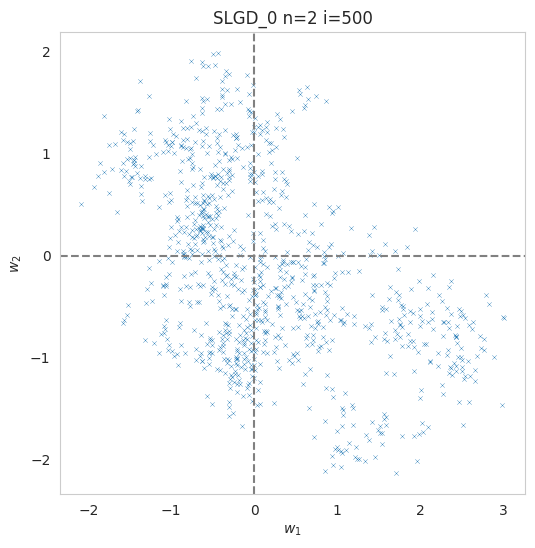

In [10]:
plot_multi_trajectories(wt_sgld, [100, 500], [0, 1, 2], f"SLGD", model=model)

## **Plot cumulant statistics of marginal distribution of jet coordinates SGLD**


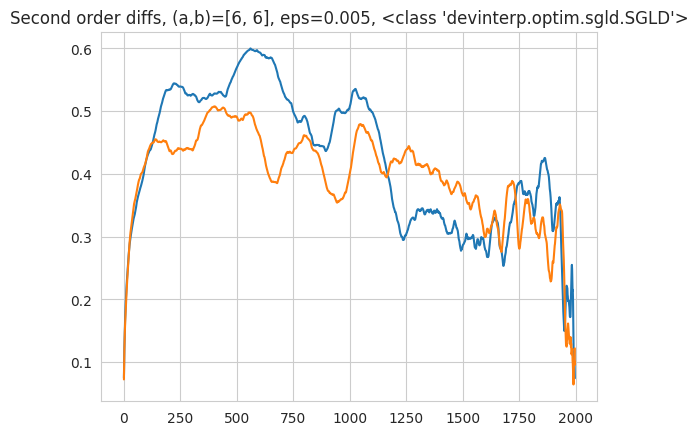

In [11]:
flattened = wt_sgld.reshape((num_chains_sgld, num_draws_sgld, -1))

plot_second_order_one_place_stats(
    flattened,
    1,
    title=f"Second order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
)

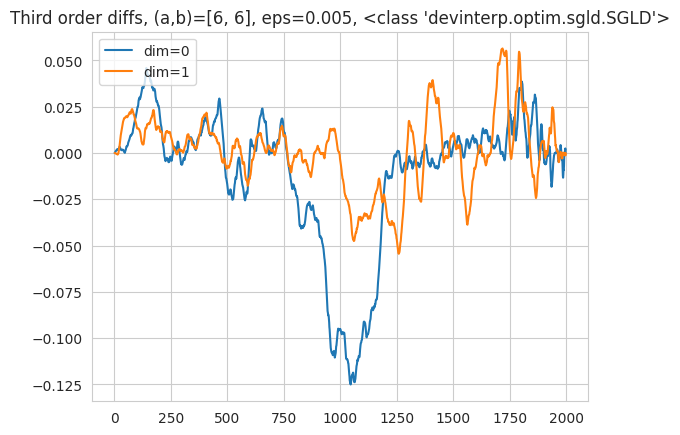

In [12]:
plot_third_order_stats_per_dim(
    flattened,
    1,
    title=f"Third order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
    up_to_dim=2,
)

## **Vector fields SGLD**

In [28]:
print(np.shape(wt_sgld[0]))
xmin = np.min(wt_sgld[0][:, :, 0])
xmax = np.max(wt_sgld[0][:, :, 0])
ymin = np.min(wt_sgld[0][:, :, 1])
ymax = np.max(wt_sgld[0][:, :, 1])
diffs = np.concatenate(joint_ith_place_nth_diff(wt_sgld, 10, 1))

vect_field = np.reshape(
    diffs,
    (
        np.shape(diffs)[0],
        np.shape(diffs)[-1],
    ),
)
print(np.shape(vect_field))
print("aa")
vect_field, colors = compute_binned_averages_multi_with_std(
    diffs, xmin, xmax, ymin, ymax, 15
)
plot_vector_field_with_colors(
    vect_field, colors[:, :, 0], xmin, xmax, ymin, ymax, 10, 1, "SGLD"
)
plot_vector_field_jets(wt_sgld[0], [10, 100, 500], [1], 15, "SGLD")

(2000, 1, 2)
(0, 4)
(0, 4)
aa


IndexError: an index can only have a single ellipsis ('...')

# **SGHNT trajectories sampling**

In [14]:
num_chains_sgnht = 1
num_draws_sgnht = 10_000

epsilon_sgnht = 0.001

In [15]:
sgnht_weights = WeightCallback(
    num_chains=num_chains_sgnht, num_draws=num_draws_sgnht, model=model
)
online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgnht,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)

trace_sgnht = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(
        lr=epsilon_sgnht, nbeta=nbeta, diffusion_factor=0.005, bounding_box_size=1.0
    ),
    sampling_method=SGNHT,
    num_chains=num_chains_sgnht,  # independent sampling runs
    num_draws=num_draws_sgnht,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, sgnht_weights],
    seed=SEED,
)

/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:225: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:264: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:291: UserWarning: You are using seeded runs, for full reproducibility check https://pytorch.org/docs/stable/notes/randomness.html
  warnings.warn(
Chain 0:  20%|██        | 2000/10000 [00:17<01:10, 113.94it/s]


IndexError: index 2000 is out of bounds for dimension 1 with size 2000

In [ ]:
wt_sgnht = np.array(sgnht_weights.get_results()["ws/trace"])

print(np.nonzero(np.isnan(wt_sgnht)))
print(epsilon_sgld * num_draws_sgnht)

# **SGNHT plots**

## **Plotting SGNHT trajectories and jet coordinates**




In [ ]:
plot_multi_trajectories(wt_sgnht, [1, 10], [0, 1, 2], "SGNHT")

## **Plot cumulant statistics of marginal distribution of jet coordinates SGNHT**

In [ ]:
flattened = wt_sgnht.reshape((num_chains_sgnht, num_draws_sgnht, -1))

plot_second_order_one_place_stats(
    flattened,
    1,
    title=f"Second order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
)

In [ ]:
plot_third_order_stats_per_dim(
    flattened,
    1,
    title=f"Third order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
    up_to_dim=2,
)

## **Vector fields SGNHT**

In [ ]:
plot_vector_field_jets(wt_sgnht, [10, 100, 500], [1], 15, "SGNHT")